In [2]:
# import pandas
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# exchange codes http://finabase.blogspot.com/2014/09/interantional-stock-exchange-codes-for.html
path = './Compustat data.csv.nosync.csv'
df_original = pd.read_csv(path, sep=',')

df_exchange = pd.read_csv('./exchange_codes.csv', sep=',')
df_exchange = df_exchange.rename(columns={'code': 'exchg'})

/Users/vini2001/miniforge3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,10,12,16,26,30,945,946,948,949,950,955,965,969,970,975) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = df_original.copy()

In [4]:
df

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1000,19611231,1961.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,19780630.0,NaN
1,1000,19621231,1962.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,19780630.0,NaN
2,1000,19631231,1963.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,19780630.0,NaN
3,1000,19641231,1964.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,19780630.0,NaN
4,1000,19651231,1965.0,INDL,C,D,STD,AE.2,000032102,A & E PLASTIK PAK INC,...,1.0,3089.0,325.0,978.0,NaN,NaN,0.0,NaN,19780630.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593069,351590,20191231,2019.0,INDL,C,D,STD,DTRUY,23384L101,DAIMLER TRUCK HOLDING AG,...,90.0,3713.0,NaN,NaN,NaN,NaN,3.0,www.daimlertruck.com,NaN,NaN
593070,351590,20201231,2020.0,INDL,C,D,STD,DTRUY,23384L101,DAIMLER TRUCK HOLDING AG,...,90.0,3713.0,NaN,NaN,NaN,NaN,3.0,www.daimlertruck.com,NaN,NaN
593071,351590,20211231,2021.0,INDL,C,D,STD,DTRUY,23384L101,DAIMLER TRUCK HOLDING AG,...,90.0,3713.0,NaN,NaN,NaN,NaN,3.0,www.daimlertruck.com,NaN,NaN
593072,353444,20211231,2021.0,INDL,C,D,STD,HLN,405552100,HALEON PLC,...,90.0,2834.0,NaN,NaN,NaN,NaN,0.0,www.haleon.com,NaN,20220718.0


### Plot companies count per exchange

Total of 42039 companies


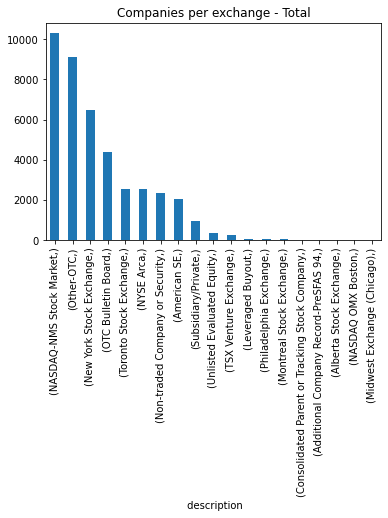

In [5]:
def plot_count_per_exchange():
    df_company = df[['exchg', 'gvkey']]
    df_company = df_company.drop_duplicates()

    unique_gvkeys = df_company['gvkey'].unique()
    print(f'Total of {len(unique_gvkeys)} companies')

    df_exchg = df_company['exchg']
    exchg = pd.merge(df_exchg, df_exchange, how='left', on='exchg')
    exchg = exchg.drop(columns=['exchg'])
    exchg.value_counts().plot(kind='bar', title='Companies per exchange - Total')

plot_count_per_exchange()

#### Remove exchanges that can't be traded for free - this excludes mainly OTC stocks - not listed on any exchange

Total of 22425 companies


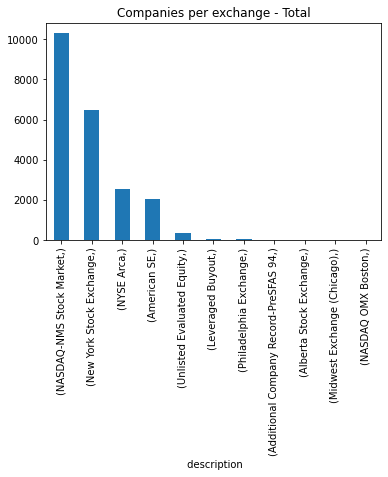

In [6]:
# drop all df rows where exchg is [0 - Subsidiary/Private, 1 - Non-traded Company or Security, 2 - Consolidated Parent or Tracking , 13 - OTCBB, 19 - Other-OTC]
df = df[df['exchg'] != 0]
df = df[df['exchg'] != 1]
df = df[df['exchg'] != 2]
df = df[df['exchg'] != 13]
df = df[df['exchg'] != 19]

# canada
df = df[df['exchg'] != 7]
df = df[df['exchg'] != 8]
df = df[df['exchg'] != 9]

plot_count_per_exchange()


In [15]:
df[(df['tic'] == 'NE') & (df['fyear'] >= 2018)][['fyear', 'mkvalt', 'csho', 'prcc_f']]

,fyear,mkvalt,csho,prcc_f
237256,2018.0,646.6003,246.794,2.620
237257,2019.0,304.0240,249.200,1.220
237258,2020.0,6.2771,251.084,0.025
237259,2021.0,1492.8673,60.172,24.810


### Remove companies without the Market Cap value

Total of 11209 companies


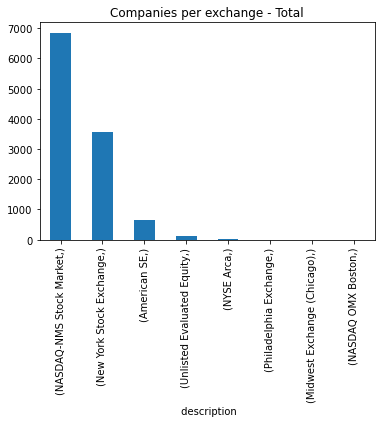

In [7]:
# remove from df rows without mktval
# This appears to exclude everything before 1989
df = df[df['mkvalt'].notna()]
plot_count_per_exchange()

### Plot companies count per year (after excluding OTC & others)

<AxesSubplot:title={'center':'Companies per year'}, xlabel='Year', ylabel='Companies'>

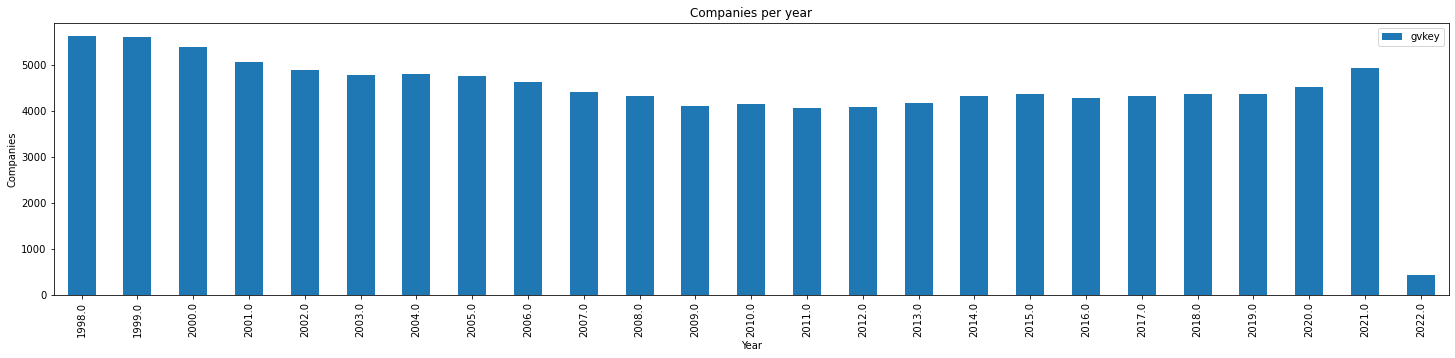

In [7]:
df_per_year = df[['fyear','gvkey']].drop_duplicates()
df_per_year = df_per_year.groupby(['fyear']).count()
df_per_year.plot(kind='bar', title='Companies per year', 
                 xlabel='Year', ylabel='Companies',
                 figsize=(25,5))


### Analyze Columns

['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt', 'tic', 'cusip', 'conm', 'acctchg', 'acctstd', 'acqmeth', 'adrr', 'ajex', 'ajp', 'bspr', 'compst', 'curcd', 'curncd', 'currtr', 'curuscn', 'final', 'fyr', 'ismod', 'ltcm', 'ogm', 'pddur', 'scf', 'src', 'stalt', 'udpl', 'upd', 'apdedate', 'fdate', 'pdate', 'acchg', 'acco', 'accrt', 'acdo', 'aco', 'acodo', 'acominc', 'acox', 'acoxar', 'acqao', 'acqcshi', 'acqgdwl', 'acqic', 'acqintan', 'acqinvt', 'acqlntal', 'acqniintc', 'acqppe', 'acqsc', 'act', 'adpac', 'aedi', 'afudcc', 'afudci', 'aldo', 'am', 'amc', 'amdc', 'amgw', 'ano', 'ao', 'aocidergl', 'aociother', 'aocipen', 'aocisecgl', 'aodo', 'aol2', 'aoloch', 'aox', 'ap', 'apalch', 'apb', 'apc', 'apofs', 'aqa', 'aqc', 'aqd', 'aqeps', 'aqi', 'aqp', 'aqpl1', 'aqs', 'arb', 'arc', 'arce', 'arced', 'arceeps', 'artfs', 'at', 'aul3', 'autxr', 'balr', 'banlr', 'bast', 'bastr', 'batr', 'bcef', 'bclr', 'bcltbl', 'bcnlr', 'bcrbl', 'bct', 'bctbl', 'bctr', 'billexce', 'bkvlps', 'bltb

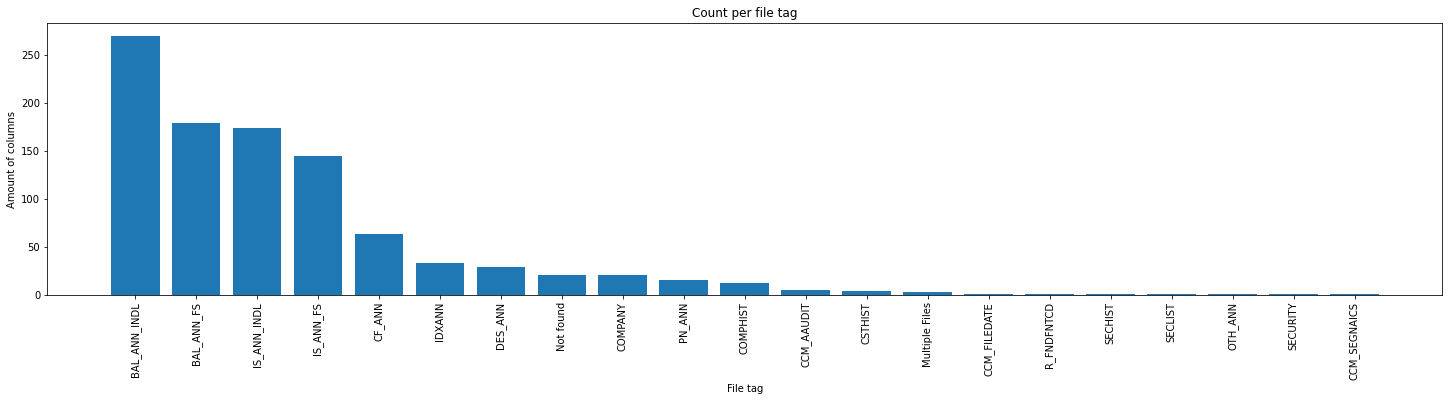

In [8]:
columns = df.columns.tolist()


path_items_descriptions = './items_descriptions.csv'
df_items_descriptions = pd.read_csv(path_items_descriptions, sep=',')
def get_description(item):
    item = item.upper()
    
    vals = df_items_descriptions[
        (df_items_descriptions['ItemName'] == item ) | 
        (df_items_descriptions['ItemHdr'] == item) |
        (df_items_descriptions['XpressfeedMnemonic'] == item) 
    ]['ItemDesc']
    return vals.values[0] if len(vals) > 0 else 'Not found'

def get_file_tag(item):
    item = item.upper()
    
    vals = df_items_descriptions[
        (df_items_descriptions['FileTag'] == item ) | 
        (df_items_descriptions['ItemHdr'] == item) |
        (df_items_descriptions['XpressfeedMnemonic'] == item) 
    ]['FileTag']
    return vals.values[0] if len(vals) > 0 else 'Not found'

print(columns)

count_per_file_tag = {}
for col in columns:
    file_tag = get_file_tag(col)
    if file_tag in count_per_file_tag:
        count_per_file_tag[file_tag] += 1
    else:
        count_per_file_tag[file_tag] = 1
count_per_file_tag

# sort by value
count_per_file_tag = {k: v for k, v in sorted(count_per_file_tag.items(), key=lambda item: item[1], reverse=True)}
count_per_file_tag

plt.figure(figsize=(25,5))
plt.bar(count_per_file_tag.keys(), count_per_file_tag.values())
plt.xticks(rotation=90)
plt.title('Count per file tag')
plt.xlabel('File tag')
plt.ylabel('Amount of columns')
plt.show()


def most_frequent_columns(df):
    map_count = {}
    for c in columns:
        map_count[c] = df[c].describe()['count']

    # sort by count
    map_count = {k: v for k, v in sorted(map_count.items(), key=lambda item: item[1], reverse=True)}

    columns_data = []
    for k, v in map_count.items():
        columns_data.append([k, v, get_description(k), get_file_tag(k)])

    df_columns = pd.DataFrame(columns_data, columns=['Column', 'Count', 'Description', 'FileTag'])
    return df_columns

df_columns = most_frequent_columns(df)

### Selecting columns x impact on number of tickers selected

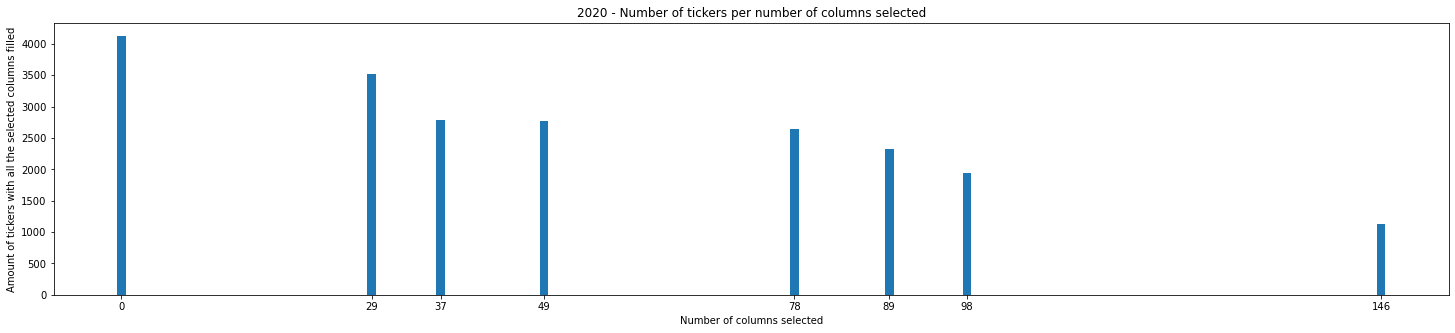

In [9]:
year_start = 2020
min_tickers_to_select_row = 4000

map_min_to_tickers = {}

for min_tickers_to_select_row in [3500, 3750, 3900, 4000, 4100, 4250, 4500, 4750, 5000]:
    # print()
    # print(f'min_tickers_to_select_row: {min_tickers_to_select_row}')
    rows_start = df[df['fyear'] == year_start]
    rows_start = rows_start.reset_index(drop=True)

    rows_start = rows_start[rows_start['datadate'] <= int(f'{year_start}1231')]

    tickers_start = rows_start['tic']
    tickers_start = set(tickers_start)
    # print(f'{len(tickers_start)} tickers in {year_start}')

    df_columns_start = most_frequent_columns(rows_start)
    path = f'./columns_{year_start}.csv'
    df_columns_start.to_csv(path, index=False)
    df_columns_start

    # select columns with count > min_count
    def select_columns(df, min_count, file_tag):
        vals = df[df_columns_start['FileTag'] == file_tag]
        vals = vals[vals['Count'] > min_count]['Column']
        return vals.values.tolist()

    vals_bal_ann_indl = select_columns(df_columns_start, min_tickers_to_select_row, 'BAL_ANN_INDL')
    vals_is_ann_indl = select_columns(df_columns_start, min_tickers_to_select_row, 'IS_ANN_INDL')

    # print(f'{len(vals_bal_ann_indl)} Balance Sheet columns')
    # print(f'{len(vals_is_ann_indl)} Income Statement columns')

    # select all rows in rows_start with columns of vals_bal_ann_indl and vals_is_ann_indl different than NaN
    rows_start_bal_and_is = rows_start[['tic', 'fyear'] + vals_bal_ann_indl + vals_is_ann_indl + ['mkvalt', 'prcc_f']]
    rows_start_bal_and_is = rows_start_bal_and_is.dropna()
    rows_start_bal_and_is = rows_start_bal_and_is.reset_index(drop=True)
    # print(f'{len(rows_start_bal_and_is)} after picking only tickers with all the selected columns filled ')

    map_min_to_tickers[len(vals_bal_ann_indl) + len(vals_is_ann_indl)] = len(rows_start_bal_and_is['tic'].unique())

# plot

plt.figure(figsize=(25,5))
plt.title('2020 - Number of tickers per number of columns selected')
plt.xlabel('Number of columns selected')
plt.ylabel('Amount of tickers with all the selected columns filled')
plt.bar(map_min_to_tickers.keys(), map_min_to_tickers.values(), width=1)
plt.xticks(list(map_min_to_tickers.keys()))
plt.show()

### Exclude companies with abnormal data that would negatively impact the results

In [10]:
# Some of these companies went bankrupt - so they were listed as OTC stocks and just later came back to being listed at a major exchange
# So we exclude them because part of the time they were OTC stocks

tickers_to_exclude = ['NE', 'EVTL', 'VAL', 'CHK', 'GPOR', 'FYBR', 'CBL', 'TUEM', 'DTLA.P']

print(df[(df['tic'] == 'NE') & (df['fyear'] > 2018)][['tic', 'datadate', 'csho', 'prcc_f', 'mkvalt']])
print()
print(df[(df['tic'] == 'EVTL') & (df['fyear'] > 2018)][['tic', 'datadate', 'csho', 'prcc_f', 'mkvalt']])
print()
print(df[(df['tic'] == 'CHK') & (df['fyear'] > 2018)][['tic', 'datadate', 'csho', 'prcc_f', 'mkvalt']])

df = df[~df['tic'].isin(tickers_to_exclude)]

       tic  datadate     csho  prcc_f     mkvalt
237257  NE  20191231  249.200   1.220   304.0240
237258  NE  20201231  251.084   0.025     6.2771
237259  NE  20211231   60.172  24.810  1492.8673

         tic  datadate     csho  prcc_f     mkvalt
418409  EVTL  20201231    0.105   10.05     1.0553
418410  EVTL  20211231  209.135    6.73  1407.4786

        tic  datadate      csho   prcc_f     mkvalt
372092  CHK  20191231  1949.314   0.8256  1609.3536
372093  CHK  20201231     9.781   1.5200    14.8671
372094  CHK  20211231   117.917  64.5200  7608.0048


### Analyze fiscal year end

Latest end: 20220531
{'202108': 270, '202109': 471, '202110': 525, '202111': 548, '202112': 5210, '202201': 5349, '202202': 5372, '202203': 5534, '202204': 5578, '202205': 5605, '202206': 5605}


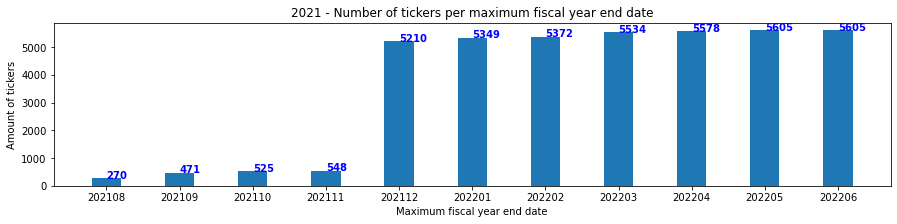

In [11]:
year_start = 2021
df2021 = df[df['fyear'] == year_start]
df2021 = df2021[['datadate']]
#sort by datadate desc
df2021 = df2021.sort_values(by=['datadate'], ascending=False)
print(f'Latest end: {df2021.head(1).values[0][0]}')

mapLimitDateToCountOfTickers = {}

monthStart = 6
for i in range(0, 11):
    monthStart += 1
    monthStartN = (monthStart % 12) + 1
    yearMonth = f'{year_start if monthStart < 12 else year_start+1}{monthStartN if monthStartN > 9 else f"0{monthStartN}"}'
    
    dfL = df2021[df2021['datadate'] <= int(f'{yearMonth}31')]
    mapLimitDateToCountOfTickers[yearMonth] = len(dfL)

print(mapLimitDateToCountOfTickers)
#plot
plt.figure(figsize=(15,3))
plt.title('2021 - Number of tickers per maximum fiscal year end date')
plt.xlabel('Maximum fiscal year end date')
plt.ylabel('Amount of tickers')
plt.bar(mapLimitDateToCountOfTickers.keys(), mapLimitDateToCountOfTickers.values(), width=0.4)
plt.xticks(list(mapLimitDateToCountOfTickers.keys()))
# show all y values on the top of the bar
for i, v in enumerate(mapLimitDateToCountOfTickers.values()):
    plt.text(i, v, str(v), color='blue', fontweight='bold')
plt.show()
